In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
from upsetplot import from_contents, UpSet
from importlib import reload
import itertools
from itertools import chain
from tqdm import tqdm
import time
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm
from scipy.stats import t, poisson
from scipy.special import factorial
from scipy.optimize import curve_fit
from scipy.sparse import csr_matrix

import utils_guide_calling as gc

In [2]:
reload(gc)

<module 'utils_guide_calling' from '/Users/janabraunger/Documents/Projects/scCRISPR/python/utils_guide_calling.py'>

In [3]:
data_dir = "../data/"
gc_dir = "../data/guide_calling/"
fig_dir = "../figures/guide_calling_schraivogel/"

# gRNA distributions

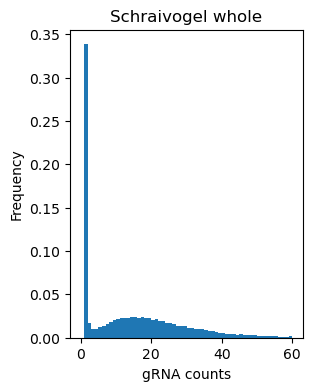

In [4]:
# plot the gRNA distribution for the whole data set
counts = pd.read_csv(data_dir + 'Schraivogel/whole/gRNA_counts.csv').set_index('gRNA')
all_values = pd.concat([counts[col] for col in counts.columns])
nonzero_values = all_values[all_values != 0]

plt.figure(figsize=(3,4))
plt.hist(nonzero_values, bins = 60, range = (0,60), density = True)  
plt.xlabel('gRNA counts')
plt.ylabel('Frequency')
plt.title('Schraivogel whole')
plt.savefig(fig_dir + 'Schraivogel_whole_gRNA_distribution.png', dpi = 500, bbox_inches="tight")
plt.show()

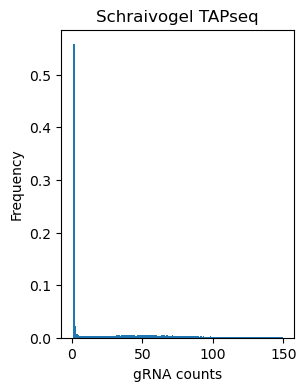

In [5]:
# plot the gRNA distribution for the TAPseq screen
counts = pd.read_csv(data_dir + 'Schraivogel/TAP/gRNA_counts.csv').set_index('gRNA')
all_values = pd.concat([counts[col] for col in counts.columns])
nonzero_values = all_values[all_values != 0]

plt.figure(figsize=(3,4))
plt.hist(nonzero_values, bins = 150, range = (0,150), density = True)  
plt.xlabel('gRNA counts')
plt.ylabel('Frequency')
plt.title('Schraivogel TAPseq')
plt.savefig(fig_dir + 'Schraivogel_TAP_gRNA_distribution.png', dpi = 500, bbox_inches="tight")
plt.show()

# Guide assignment intersections 

In [6]:
def get_perturbations(file_name, method_name):
    perturbations = pd.read_csv(file_name)[['cell', 'gRNA']]
    perturbations['method'] = method_name
    return perturbations

def get_single_assignments(perturbations):
    grouped_df = perturbations.drop_duplicates()
    grouped_df = grouped_df.groupby(['method', 'cell']).size().reset_index(name='pert_count')
    single_perturbations = perturbations.merge(grouped_df, on=['method', 'cell'])
    single_perturbations = single_perturbations[single_perturbations['pert_count'] == 1]
    return single_perturbations

In [7]:
# Schraivogel whole
# Varying ratios
ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ratio_perturbations = pd.DataFrame()
for ratio in ratios: 
    ratio_cells = get_perturbations(gc_dir + 'Schraivogel_whole/ratios/perturbations_t' + str(ratio) + '.csv', ratio * 100)
    ratio_perturbations = pd.concat([ratio_perturbations, ratio_cells])
ratio_perturbations.to_csv(gc_dir + 'Schraivogel_whole/ratios/all_assignments.csv')

# Varying UMI threshold
UMI_ts = [1,2,3,4,5,6,7,8,9,10]
UMI_perturbations = pd.DataFrame()
for t in UMI_ts: 
    UMI_cells = get_perturbations(gc_dir + 'Schraivogel_whole/UMI_t/perturbations_t' + str(t) + '.csv', t)
    UMI_perturbations = pd.concat([UMI_perturbations, UMI_cells])
UMI_perturbations.to_csv(gc_dir + 'Schraivogel_whole/UMI_t/all_assignments.csv')
    
# Varying quantile threshold
quantile_ts = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
q_perturbations = pd.DataFrame()
for t in quantile_ts: 
    q_cells = get_perturbations(gc_dir + 'Schraivogel_whole/quantiles/perturbations_q' + str(t) + '.csv', t * 100)
    q_perturbations = pd.concat([q_perturbations, q_cells])
q_perturbations.to_csv(gc_dir + 'Schraivogel_whole/quantiles/all_assignments.csv')

# Filter to single assignments
ratio_perturbations = get_single_assignments(ratio_perturbations)
ratio_perturbations.to_csv(gc_dir + 'Schraivogel_whole/ratios/single_assignments.csv')

UMI_perturbations = get_single_assignments(UMI_perturbations)
UMI_perturbations.to_csv(gc_dir + 'Schraivogel_whole/UMI_t/single_assignments.csv')

q_perturbations = get_single_assignments(q_perturbations)
q_perturbations.to_csv(gc_dir + 'Schraivogel_whole/quantiles/single_assignments.csv')

In [9]:
# Schraivogel TAP
# Varying ratios
ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ratio_perturbations = pd.DataFrame()
for ratio in ratios: 
    ratio_cells = get_perturbations(gc_dir + 'Schraivogel_TAP/ratios/perturbations_t' + str(ratio) + '.csv', ratio * 100)
    ratio_perturbations = pd.concat([ratio_perturbations, ratio_cells])
ratio_perturbations.to_csv(gc_dir + 'Schraivogel_TAP/ratios/all_assignments.csv')

# Varying UMI threshold
UMI_ts = [2,3,4,5,6,7,8,9,10,15,20,25,30,40,50]
UMI_perturbations = pd.DataFrame()
for t in UMI_ts: 
    UMI_cells = get_perturbations(gc_dir + 'Schraivogel_TAP/UMI_t/perturbations_t' + str(t) + '.csv', t)
    UMI_perturbations = pd.concat([UMI_perturbations, UMI_cells])
UMI_perturbations.to_csv(gc_dir + 'Schraivogel_TAP/UMI_t/all_assignments.csv')
    
# Varying quantile threshold
quantile_ts = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
q_perturbations = pd.DataFrame()
for t in quantile_ts: 
    q_cells = get_perturbations(gc_dir + 'Schraivogel_TAP/quantiles/perturbations_q' + str(t) + '.csv', t * 100)
    q_perturbations = pd.concat([q_perturbations, q_cells])
q_perturbations.to_csv(gc_dir + 'Schraivogel_TAP/quantiles/all_assignments.csv')

# Filter to single assignments
ratio_perturbations = get_single_assignments(ratio_perturbations)
ratio_perturbations.to_csv(gc_dir + 'Schraivogel_TAP/ratios/single_assignments.csv')

UMI_perturbations = get_single_assignments(UMI_perturbations)
UMI_perturbations.to_csv(gc_dir + 'Schraivogel_TAP/UMI_t/single_assignments.csv')

q_perturbations = get_single_assignments(q_perturbations)
q_perturbations.to_csv(gc_dir + 'Schraivogel_TAP/quantiles/single_assignments.csv')

In [12]:
# read in assignments from various methods
file_dir = {'2-Beta': gc_dir + 'Schraivogel_whole/2-BetaMM/perturbations.csv',
            '3-Beta': gc_dir + 'Schraivogel_whole/3-BetaMM/perturbations.csv',
            'Binomial': gc_dir + 'Schraivogel_whole/binomial/perturbations.csv',
            'Cellranger': gc_dir + 'Schraivogel_whole/gauss/batch1/perturbations.csv',
            'Maximum': gc_dir + 'Schraivogel_whole/max/perturbations.csv',
            'Negative Binomial': gc_dir + 'Schraivogel_whole/negative_binomial/perturbations.csv',
            'top_55%_cells': gc_dir + 'Schraivogel_whole/quantiles/perturbations_q0.35.csv',
            'Replogle': gc_dir + 'Schraivogel_whole/replogle/perturbations.csv',
            'UMI_t4': gc_dir + 'Schraivogel_whole/UMI_t/perturbations_t7.csv',
            'ratio_40%': gc_dir + 'Schraivogel_whole/ratios/perturbations_t0.5.csv',
            'SCEPTRE': gc_dir + 'Schraivogel_whole/SCEPTRE/perturbations.csv'}

perturbations = pd.DataFrame()
for method_name, file_name in file_dir.items():
    p = get_perturbations(file_name, method_name)
    perturbations = pd.concat([perturbations, p])

In [14]:
# read in assignments from various methods
file_dir = {'2-Beta': gc_dir + 'Schraivogel_TAP/2-BetaMM/perturbations.csv',
            '3-Beta': gc_dir + 'Schraivogel_TAP/3-BetaMM/perturbations.csv',
            'Binomial': gc_dir + 'Schraivogel_TAP/binomial/perturbations.csv',
            'Cellranger': gc_dir + 'Schraivogel_TAP/gauss/batch1/perturbations.csv',
            'Maximum': gc_dir + 'Schraivogel_TAP/max/perturbations.csv',
            'Negative Binomial': gc_dir + 'Schraivogel_TAP/negative_binomial/perturbations.csv',
            'top_35%_cells': gc_dir + 'Schraivogel_TAP/quantiles/perturbations_q0.35.csv',
            'Replogle': gc_dir + 'Schraivogel_TAP/replogle/perturbations.csv',
            'UMI_t7': gc_dir + 'Schraivogel_TAP/UMI_t/perturbations_t7.csv',
            'ratio_50%': gc_dir + 'Schraivogel_TAP/ratios/perturbations_t0.5.csv',
            'SCEPTRE': gc_dir + 'Schraivogel_TAP/SCEPTRE/perturbations.csv'}

perturbations = pd.DataFrame()
for method_name, file_name in file_dir.items():
    p = get_perturbations(file_name, method_name)
    perturbations = pd.concat([perturbations, p])

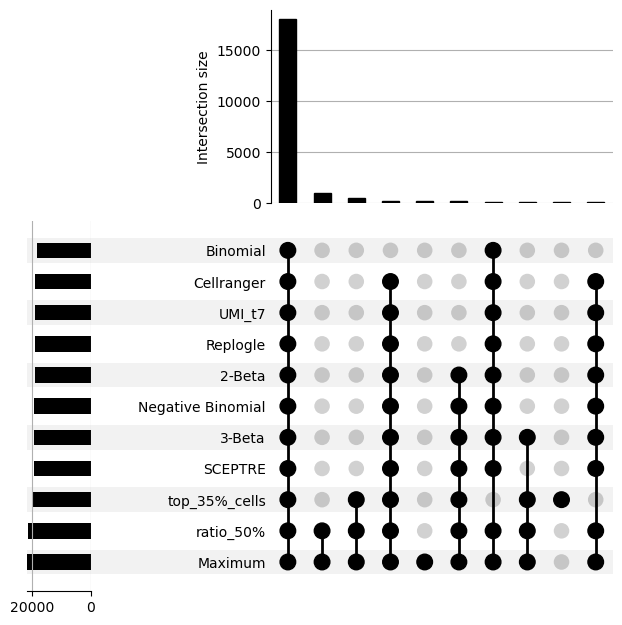

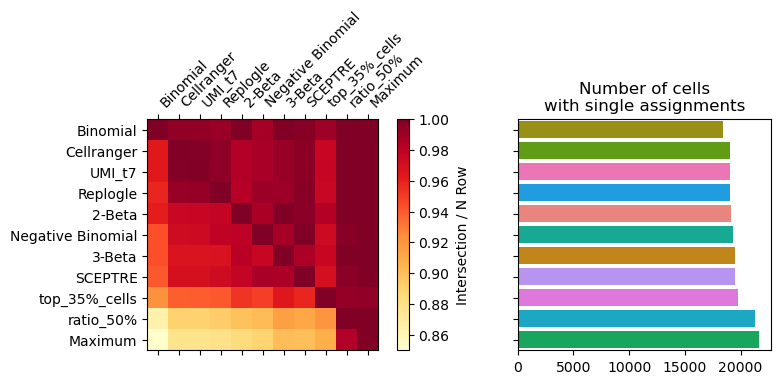

In [16]:
# Filtering for cells with single perturbations
grouped_df = perturbations.drop_duplicates()
grouped_df = grouped_df.groupby(['method', 'cell']).size().reset_index(name='pert_count')
single_perturbations = perturbations.merge(grouped_df, on=['method', 'cell'])
single_perturbations = single_perturbations[single_perturbations['pert_count'] == 1]

# Upset plot
gc.plot_intersections(single_perturbations)
plt.savefig(fig_dir + 'schraivogel_gc_upset.png', dpi = 500, bbox_inches="tight")
plt.show()

# Heatmap
colors = pd.read_csv(data_dir + 'sceptre_pipeline/schraivogel_TAP/colors.csv')
colors = colors.set_index('method')['color'].to_dict()
gc.plot_intersection_heatmap(single_perturbations, colors)
plt.savefig(fig_dir + 'schraivogel_TAP_gc_heatmap.png', dpi = 500, bbox_inches="tight")
plt.show()

In [55]:
# save single assigned cell df for usage in R
selected_df = single_perturbations.loc[:, ['cell', 'gRNA', 'method']].drop_duplicates()
selected_df.to_csv(gc_dir+'Schraivogel_whole/single_assignments_all_methods.csv', index = False)

In [28]:
# add the target gene
single_perturbations['target_gene'] = single_perturbations['gRNA'].apply(lambda x: x.split('_')[3])

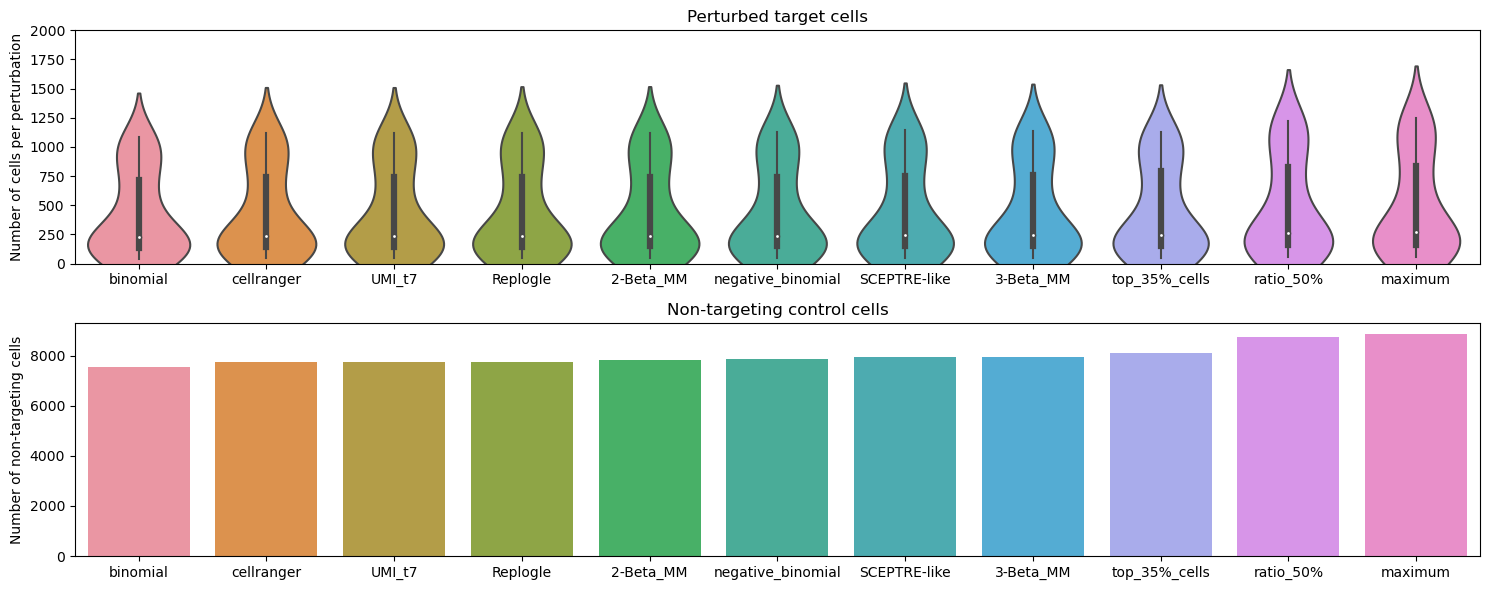

In [29]:
targeting = single_perturbations[single_perturbations['target_gene'] != 'non-targeting']
non_targeting = single_perturbations[single_perturbations['target_gene'] == 'non-targeting']

fig, axs = plt.subplots(figsize = (15, 6), nrows = 2, ncols = 1)

# create barplot of the total number non-targeting control cells per method
nt = non_targeting[['cell', 'method']].drop_duplicates().groupby('method').size().reset_index(name='cells')
nt = nt.sort_values(by='cells')
sns.barplot(data = nt, x = "method", y = "cells", ax = axs[1])
axs[1].set_xlabel('')
axs[1].set_ylabel('Number of non-targeting cells')
axs[1].set_title('Non-targeting control cells')

# create boxplots of the number of cells per perturbation
targeting = targeting[['cell', 'gRNA', 'target_gene', 'method']].drop_duplicates()
targeting = targeting.groupby(['method', 'target_gene']).size().reset_index(name = 'cells')
sns.violinplot(data = targeting, x = "method", y = "cells", ax = axs[0], order = nt['method'])
axs[0].set_ylim(0, 2000)
axs[0].set_xlabel('')
axs[0].set_ylabel('Number of cells per perturbation')
axs[0].set_title('Perturbed target cells')

plt.tight_layout()
plt.savefig(fig_dir + 'n_assigned_cells_TAP.png', dpi = 500, bbox_inches="tight")
plt.show()